# Telugu Meme Classification using CLIP and Transformer-based Multimodal Approach

## 1. Imports and Configurations

In [ ]:
!pip install transformers timm torchvision torch indic-nlp-library langdetect

In [1]:

import os
import json
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel
from torchvision import transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 2. Load and Preprocess Dataset

In [3]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

data_path = "/content/drive/MyDrive/Dataset/final_data.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Shuffle and convert to DataFrame
random.shuffle(data)
df = pd.DataFrame(data)

# Split
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)


## 3. Custom Dataset and Dataloader

In [5]:

class MemeDataset(Dataset):
    def __init__(self, dataframe, processor, tokenizer, max_length=128):
        self.data = dataframe
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image = Image.open(item['img']).convert("RGB")
        image_input = self.processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        text_input = self.tokenizer(item['text'], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            'image': image_input,
            'input_ids': text_input['input_ids'].squeeze(0),
            'attention_mask': text_input['attention_mask'].squeeze(0),
            'label': torch.tensor(item['label'], dtype=torch.long)
        }

clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
text_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

train_dataset = MemeDataset(train_df, clip_processor, text_tokenizer)
test_dataset = MemeDataset(test_df, clip_processor, text_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

## 4. Multimodal Model Architecture

In [6]:

class MultimodalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.text_model = AutoModel.from_pretrained("bert-base-multilingual-cased")
        self.fc = nn.Linear(self.clip.config.projection_dim + self.text_model.config.hidden_size, 2)

    def forward(self, image, input_ids, attention_mask):
        with torch.no_grad():
            img_features = self.clip.get_image_features(image)
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_output.last_hidden_state[:, 0, :]
        combined = torch.cat((img_features, text_features), dim=1)
        return self.fc(combined)

model = MultimodalClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

## 5. Training Loop

In [16]:
# train_losses, train_accuracies = [], []
# epochs = 5

# for epoch in range(epochs):
#     model.train()
#     total_loss, total_correct = 0, 0
#     for batch in tqdm(train_loader):
#         optimizer.zero_grad()
#         image = batch['image'].to(device)
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['label'].to(device)

#         outputs = model(image, input_ids, attention_mask)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         preds = outputs.argmax(dim=1)
#         total_correct += (preds == labels).sum().item()

#     avg_loss = total_loss / len(train_loader)
#     accuracy = total_correct / len(train_dataset)
#     train_losses.append(avg_loss)
#     train_accuracies.append(accuracy)
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Sample Text: india najmitmen mom chai mai cockroach hai china h wow mom cockraoch tea
True Label: 0
Predicted Label: 1


In [18]:
train_losses, train_accuracies, val_accuracies = [], [], []
epochs = 6

for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss, total_correct = 0, 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(image, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / len(train_dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for batch in tqdm(test_loader):  # or use a validation set if you have one
            image = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(image, input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    # Print results
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


100%|██████████| 27/27 [00:13<00:00,  1.94it/s]


Epoch 1/6, Train Loss: 0.0805, Train Accuracy: 0.9648, Val Accuracy: 0.8498


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch 2/6, Train Loss: 0.0661, Train Accuracy: 0.9730, Val Accuracy: 0.8146


100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Epoch 3/6, Train Loss: 0.0696, Train Accuracy: 0.9654, Val Accuracy: 0.8333


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch 4/6, Train Loss: 0.0632, Train Accuracy: 0.9724, Val Accuracy: 0.8263


100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


Epoch 5/6, Train Loss: 0.0848, Train Accuracy: 0.9619, Val Accuracy: 0.8075


100%|██████████| 27/27 [00:17<00:00,  1.51it/s]

Epoch 6/6, Train Loss: 0.0456, Train Accuracy: 0.9771, Val Accuracy: 0.8310


In [19]:
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(image, input_ids, attention_mask)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Test Accuracy: 0.8309859154929577
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       204
           1       0.88      0.79      0.83       222

    accuracy                           0.83       426
   macro avg       0.83      0.83      0.83       426
weighted avg       0.84      0.83      0.83       426



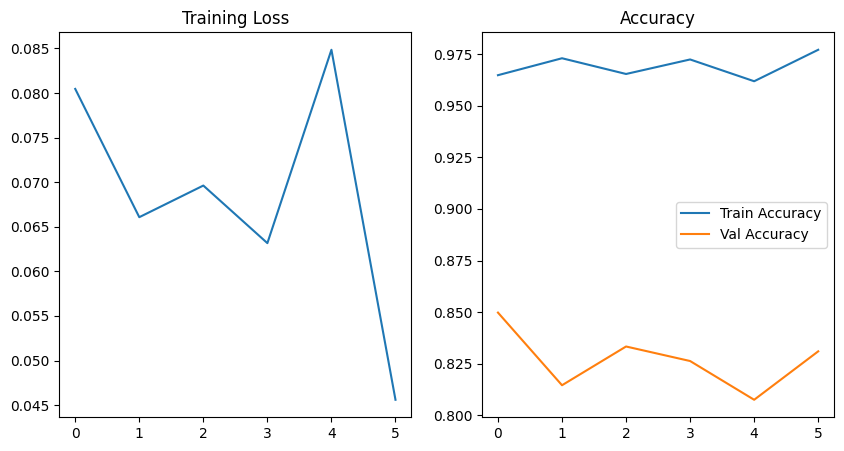

In [20]:
# Optionally, plot the losses and accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

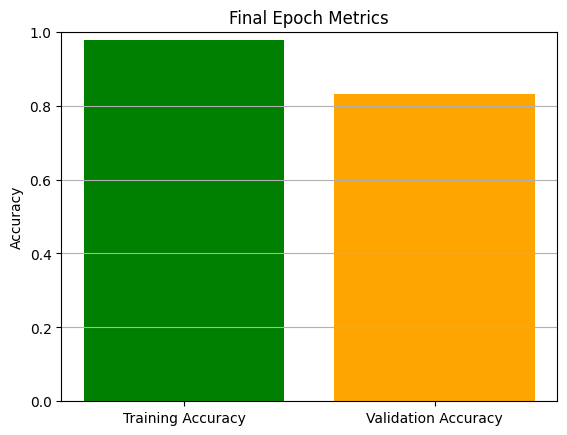

In [25]:
final_metrics = [train_accuracies[-1], val_accuracies[-1]]
labels = ['Training Accuracy', 'Validation Accuracy']

plt.bar(labels, final_metrics, color=['green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Final Epoch Metrics')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.grid(axis='y')
plt.show()

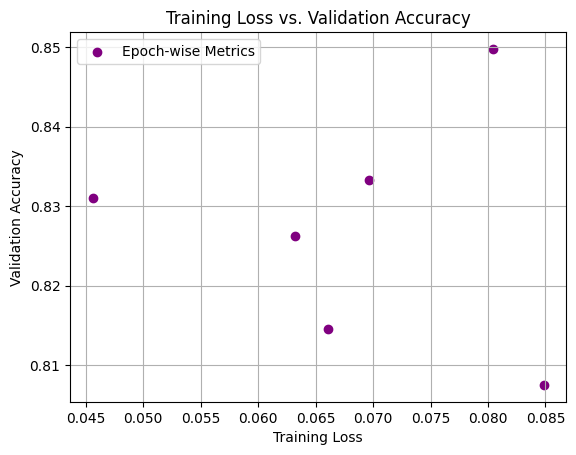

In [26]:
plt.scatter(train_losses, val_accuracies, color='purple', label='Epoch-wise Metrics')
plt.xlabel('Training Loss')
plt.ylabel('Validation Accuracy')
plt.title('Training Loss vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

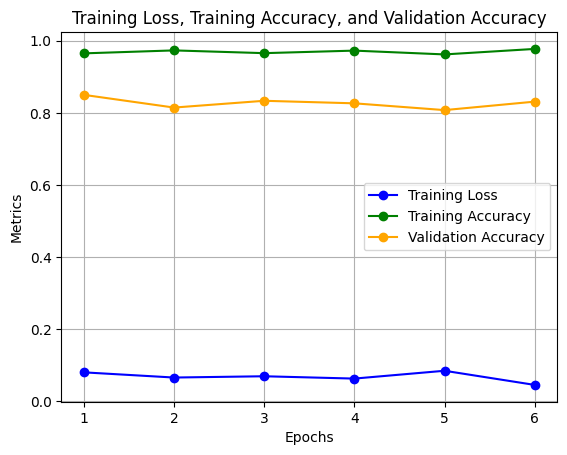

In [24]:
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='green')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Loss, Training Accuracy, and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

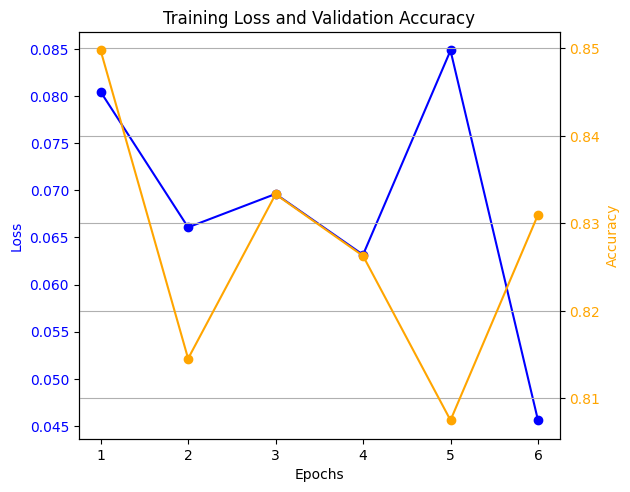

In [23]:
fig, ax1 = plt.subplots()

# Plot Training Loss
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='blue')
ax1.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Validation Accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='orange')
ax2.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.tight_layout()
plt.title('Training Loss and Validation Accuracy')
plt.grid()
plt.show()

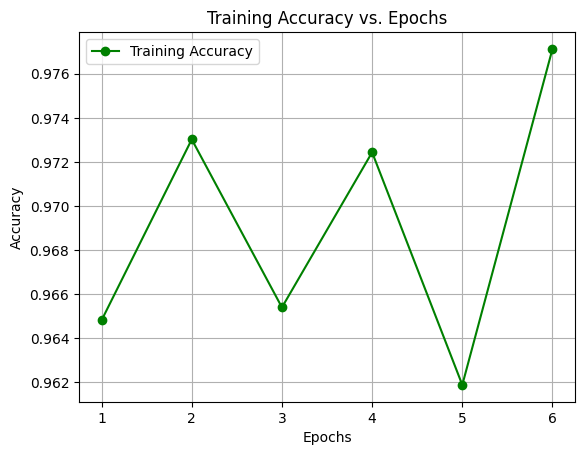

In [22]:
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()

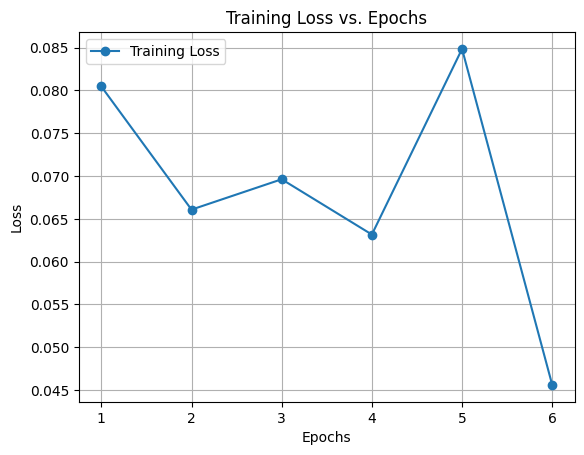

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid()
plt.show()

## 6. Evaluation and Classification Report

In [8]:
model.eval()

MultimodalClassifier(
  (clip): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bi

In [9]:
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(image, input_ids, attention_mask)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:")
print(classification_report(all_labels, all_preds))


Test Accuracy: 0.8286384976525821
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       204
           1       0.84      0.83      0.84       222

    accuracy                           0.83       426
   macro avg       0.83      0.83      0.83       426
weighted avg       0.83      0.83      0.83       426



In [13]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

test_loss, test_correct = 0, 0
val_losses = []
val_accuracies = []

with torch.no_grad():
    for batch in test_loader:
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(image, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        preds = outputs.argmax(dim=1)

        test_loss += loss.item()
        test_correct += (preds == labels).sum().item()

# Average test values
avg_test_loss = test_loss / len(test_loader)
avg_test_acc = test_correct / len(test_dataset)

val_losses.append(avg_test_loss)
val_accuracies.append(avg_test_acc)


## 7. Plotting Training Loss and Accuracy

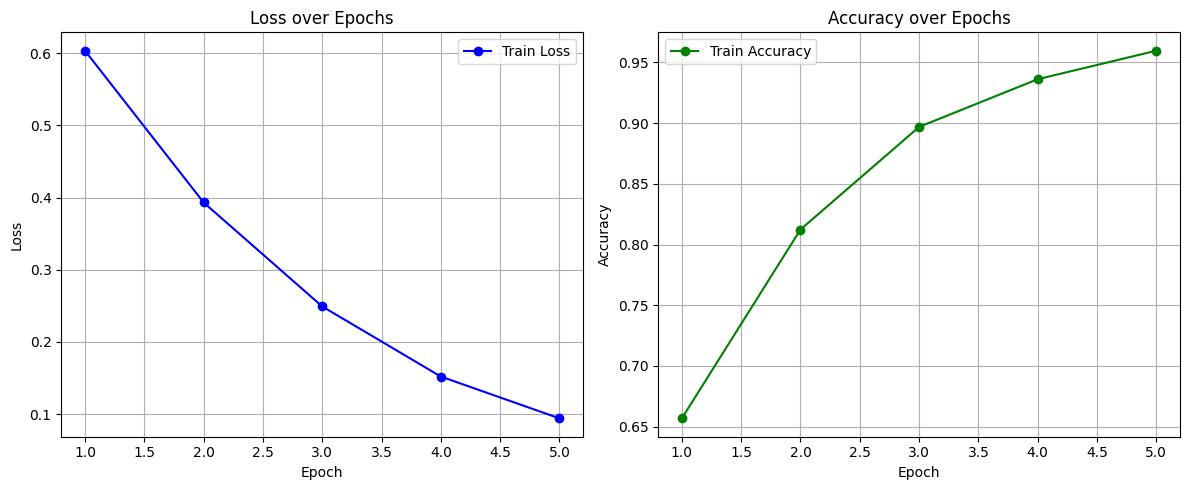

In [15]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", color="blue", marker='o')
# plt.plot(epochs_range, val_losses * epochs, label="Test Loss", color="red", linestyle='--', marker='x')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", color="green", marker='o')
# plt.plot(epochs_range, val_accuracies * epochs, label="Test Accuracy", color="orange", linestyle='--', marker='x')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 8. Confusion Matrix

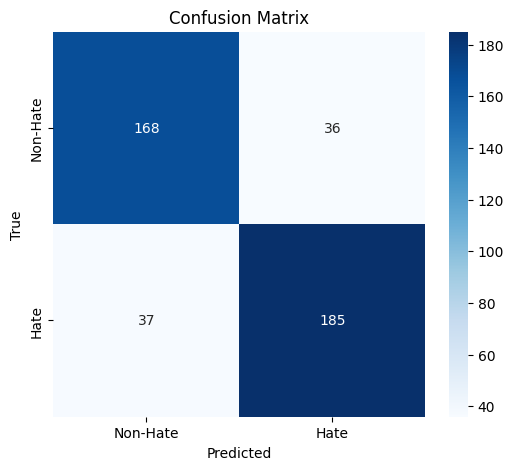

In [12]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Function for prediction

In [ ]:
def predict_sample(model, sample_text, tokenizer, device="cuda"):
    model.eval()
    encoding = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        prediction = output.argmax(dim=1).item()  # Get the predicted label (0 or 1)

    return prediction

# Sample input from the test dataset
sample = test_df.iloc[0]  # Replace with the index of the sample you want to predict
sample_text = sample['text']
sample_label = sample['label']

# Make prediction for the sample
predicted_label = predict_sample(model, sample_text, tokenizer)
print(f"Sample Text: {sample_text}")
print(f"True Label: {sample_label}")
print(f"Predicted Label: {predicted_label}")


In [28]:
# Prediction function for a sample
def predict_sample(model, sample, processor, tokenizer, device="cuda"):
    model.eval()
    image = Image.open(sample['img']).convert("RGB")
    image_input = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0).to(device)
    text_input = tokenizer(sample['text'], padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(image_input.unsqueeze(0), text_input['input_ids'], text_input['attention_mask'])
        prediction = outputs.argmax(dim=1).item()

    return prediction

# Example: Predict a sample from the test dataset
sample = test_df.iloc[5]  # Select a sample from the test set
predicted_label = predict_sample(model, sample, clip_processor, text_tokenizer)
print(f"Sample Text: {sample['text']}")
print(f"True Label: {sample['label']}")
print(f"Predicted Label: {predicted_label}")

Sample Text: yentoy sudheer boat husthe eppudu vacchinda anipinchind horor bearer antey mundhu maintain cheyatma valla ee movie ki inka easy yyindi nee body chusa feese katt 11
True Label: 0
Predicted Label: 0


In [30]:
import matplotlib.image as mpimg

**************************************************


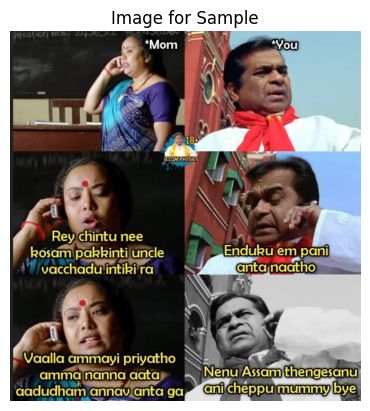

Sample Text: mom you rev chintu nee kosam pakkinti uncle vacchadu intiki ra 18 bcom physics enduku em pani anta naatho vaalla ammayi priyatho amma nanna aata aadudham annav anta ga nenu assam thengesanu ani cheppu mummy bye
True Label: 0
Predicted Label: 0
**************************************************


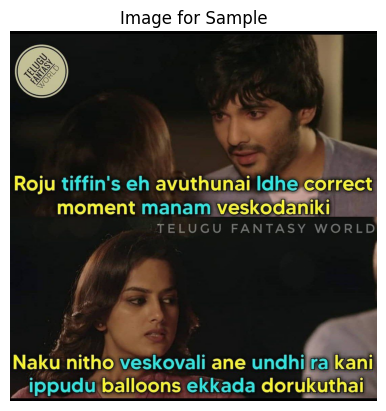

Sample Text: telugu fantasy roju tiffins ch avuthunai idhe correct moment maham veskodaniki gu fantasy world naku nitho veskovali ane undhi ra kani ippudu balloons ekkada dorukuthai
True Label: 1
Predicted Label: 1
**************************************************


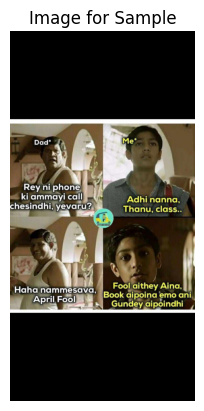

Sample Text: dad rey ni phone ki ammayi call chesindhi yevaru adhi nanna thanu class haha nammesava april fool fool aithey aina book dipoina emo ani gundey aipoindhi
True Label: 0
Predicted Label: 0
**************************************************


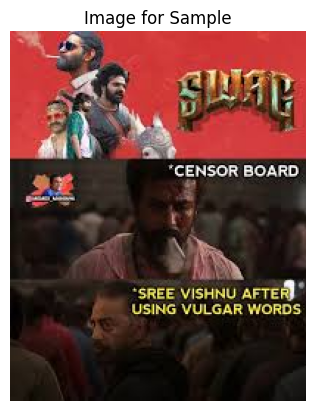

Sample Text: censor board sree vishnu after using vulgar words
True Label: 1
Predicted Label: 0
**************************************************


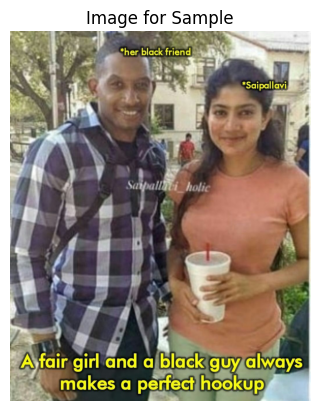

Sample Text: her black friend wall cholic saipallavi a fair girl and a black guy always makes a perfect hookup
True Label: 1
Predicted Label: 1
**************************************************


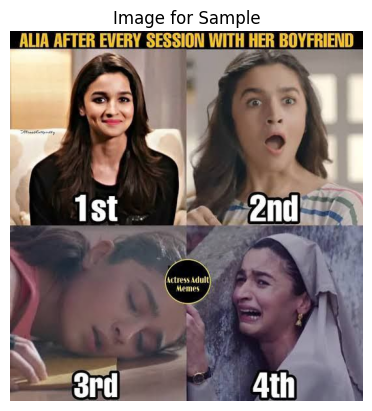

Sample Text: alia after every session with her boyfriend 1st actress adult hemnes 2nd 3rd 4th
True Label: 1
Predicted Label: 0


In [34]:
for i in range(101,107):
    sample = test_df.iloc[i]
    predicted_label = predict_sample(model, sample, clip_processor, text_tokenizer)
    print("*" * 50)
    image_path = sample['img']
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Image for Sample")
    plt.axis('off')  # Hide axis ticks and labels
    plt.show()
    print(f"Sample Text: {sample['text']}")
    print(f"True Label: {sample['label']}")
    print(f"Predicted Label: {predicted_label}")